In [1]:
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,GenericMask
from detectron2.utils.visualizer import _create_text_labels
from detectron2.data import MetadataCatalog

import sys
import os
sys.path.append('/home/josmar/proyectos/centermask2')

from centermask.config import get_cfg
import cv2
import numpy

import matplotlib.pyplot as plt

import wandb


In [2]:
def show_image(img):
  rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.imshow(rgb_img)
  plt.show()

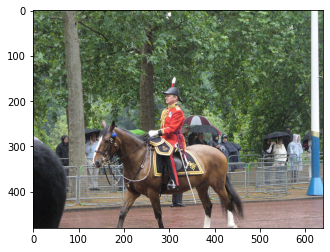

In [3]:
im = cv2.imread('test_images/input.jpg')
show_image(im)

In [4]:
#wandb init
wandb.init(project="detectron2_prediction")

config = wandb.config          # Initialize config
config.cfg_file = "centermask_V_39_eSE_FPN_ms_3x.yaml"
config.weights_file = "centermask2-V-39-eSE-FPN-ms-3x.pth"         # input batch size for training (default: 64)


# Create config
cfgs_path = "/home/josmar/proyectos/centermask2/configs/centermask/"
weights_path = "/home/josmar/proyectos/centermask2/"
cfg = get_cfg()
cfg.merge_from_file(cfgs_path + config.cfg_file)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = weights_path + config.weights_file

# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# show_image(v.get_image())
cv2.imshow("visualizacion",v.get_image()[:, :, ::-1])
k = cv2.waitKey(0)
if k == 27: # wait for ESC key to exit
  cv2.destroyAllWindows()

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Config '/home/josmar/proyectos/centermask2/configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


### Uploading boxes to wandb
To upload images to wandb it's necessary to enter the data in this way:
```python
class_id_to_label = {
    1: "car",
    2: "road",
    3: "building",
    ....
}

img = wandb.Image(image, boxes={
    "predictions": {
        "box_data": [{
            "position": {
                "minX": 0.1,
                "maxX": 0.2,
                "minY": 0.3,
                "maxY": 0.4,
            },
            "class_id" : 2,
            "box_caption": "minMax(pixel)",
            "scores" : {
                "acc": 0.1,
                "loss": 1.2
            },
        }, 
        # Log as many boxes as needed
        ...
        ],
        "class_labels": class_id_to_label
    },
    "ground_truth": {
    # Log each group of boxes with a unique key name
    ...
    }
})

wandb.log({"driving_scene": img})
```

In [17]:
import numpy as np
import cv2
predictions = outputs["instances"].to("cpu")
boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
scores = predictions.scores if predictions.has("scores") else None

Obtaining the xmin,xmax,ymin,ymax values

In [19]:
# print(predictions.pred_classes)
h, w, ch = I.shape
np_boxes = boxes.tensor.numpy()
x = np_boxes[:,[0,2]]
y = np_boxes[:,[1,3]]
x = x/w
y = y/h
x=x.tolist()
y=y.tolist()
box_scores = scores.numpy()
print(box_scores.dtype)
box_scores = box_scores.astype(np.float64)
box_scores = np.round(box_scores,2)
print(box_scores.dtype)

names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).get("thing_classes", None)
classes = np.asarray(predictions.pred_classes).tolist()
id2label={}
i=0
for n in names:
    id2label[i] =  names[i]
    i+=1

float32
float64


In [20]:
box_data = []
for i in range(len(classes)):
    _id = classes[i]
    b = create_box(x[i],y[i], _id, box_scores[i], id2label[_id])
    box_data.append(b)

In [23]:

img = wandb.Image(cv2.cvtColor(I,cv2.COLOR_BGR2RGB), boxes={
    "predictions": {
        "box_data": box_data,
        "class_labels": id2label
    },
})
wandb.log({"driving_scene": img})

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Uploading masks to wandb

In [10]:
predictions = outputs["instances"].to("cpu")
boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
scores = predictions.scores if predictions.has("scores") else None
classes = predictions.pred_classes if predictions.has("pred_classes") else None
# labels = _create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

In [11]:
import numpy as np
masks = np.asarray(predictions.pred_masks)
print (np.asarray(classes))

[ 0 17  0  0  0  0  0  0 25 25  0  0  0 25  0 25  0  0  0  0  0 25  0  0
  0 17 17 25 25  0  0 26 24  0  0  0  0 25  0  0  0  0 25  0 17  0 11 13
 13 26]


In [12]:
names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).get("thing_classes", None)
classes = np.asarray(predictions.pred_classes)
class_labels={}
for c in classes:
    class_labels[c] =  names[c]
class_labels[-1] = "background"
print(class_labels)

{0: 'person', 17: 'horse', 25: 'umbrella', 26: 'handbag', 24: 'backpack', 11: 'stop sign', 13: 'bench', -1: 'background'}


### Timer


In [13]:
import time
import timer
timer.reset()
timer.start("Proceso1")
time.sleep(1)
timer.stop("Proceso1")
with timer.env("Proc2"):
    time.sleep(2)





In [14]:
timer.print_stats()
print(timer.total_time())


   Name   | Time (ms)  
----------+------------
 Proceso1 |  1001.2458 
    Proc2 |  2002.0401 
----------+------------
    Total |  3003.2859 

3.0032859409999944


## Test models

### Box functions

In [2]:
def create_box(x,y,_id,score,label):
    box = {
        "position": {
            "minX": x[0],
            "maxX": x[1],
            "minY": y[0],
            "maxY": y[1],
        },
        "class_id" : _id,
            "box_caption": "{} ({})".format(label,score),
            "scores" : {
                "score": score
            }
    }
    
    return box

In [3]:
import numpy as np
import cv2
def wandb_boxes(im, outputs):
    predictions = outputs["instances"].to("cpu")
    boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
    scores = predictions.scores if predictions.has("scores") else None
    names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).get("thing_classes", None)
    classes = np.asarray(predictions.pred_classes).tolist()

    h, w, ch = im.shape
    np_boxes = boxes.tensor.numpy()
    x = np_boxes[:,[0,2]]
    y = np_boxes[:,[1,3]]
    x = x/w
    y = y/h
    x=x.tolist()
    y=y.tolist()
    box_scores = scores.numpy()
    box_scores = box_scores.astype(np.float64)
    box_scores = np.round(box_scores,2)
    
    id2label={}
    i=0
    for n in names:
        id2label[i] =  names[i]
        i+=1
    box_data = []
    for i in range(len(classes)):
        _id = classes[i]
        b = create_box(x[i],y[i], _id, box_scores[i], id2label[_id])
        box_data.append(b)
    
    img = wandb.Image(im, boxes={
        "predictions": {
            "box_data": box_data,
            "class_labels": id2label
        },
    })
    # wandb.log({name: img})
    return img

In [4]:
import wandb 
wandb.init(project="detectron2_prediction")
os.environ['WANDB_NOTEBOOK_NAME'] = 'outside.ipynb' 

config = wandb.config          # Initialize config
config.cfg_file = "centermask_V_39_eSE_FPN_ms_3x.yaml"
config.weights_file = "centermask2-V-39-eSE-FPN-ms-3x.pth"         # input batch size for training (default: 64)


# Create config
cfgs_path = "/home/josmar/proyectos/centermask2/configs/centermask/"
weights_path = "/home/josmar/proyectos/centermask2/"

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


### Register Annotations

In [5]:
from detectron2.data.datasets import register_coco_instances
reg_name = "coco_2017_val"
ann_path = "../extracted_classes/person_val_2017_mini.json"
img_path = "datasets/coco/val2017"
# register_coco_instances(reg_name, {}, ann_path, img_path)

### Verify the dataset info

In [6]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np
# initialize COCO api for instance annotations
coco=COCO(ann_path)
# get all images containing given categories, select one at random
category = "person"
catIds = coco.getCatIds(catNms=[category])
imgIds = coco.getImgIds(catIds=catIds )
# Get 3 random images
imgs = coco.loadImgs(np.random.choice(imgIds, 3))

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


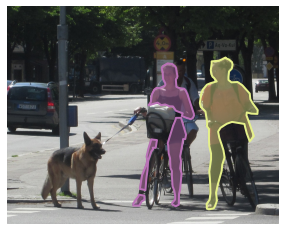

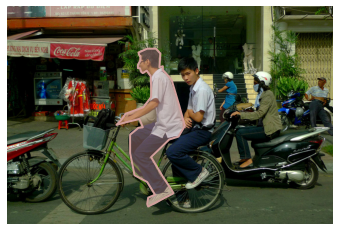

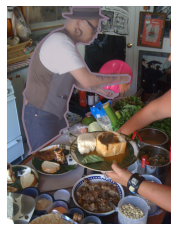

In [7]:
for img in imgs:
    I=plt.imread(os.path.join(img_path, img['file_name']))
    plt.axis('off')
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)
    plt.show()

In [9]:
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (reg_name,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
# trainer.train()

[08/24 12:24:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [10]:

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = (reg_name, )
predictor = DefaultPredictor(cfg)

In [11]:
from detectron2.data import DatasetCatalog, MetadataCatalog
my_metadata = MetadataCatalog.get(reg_name)

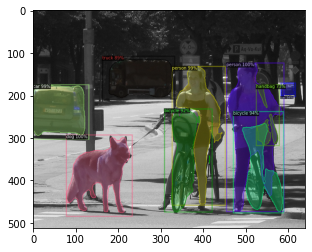

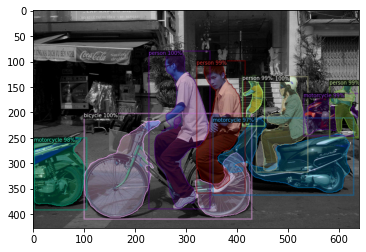

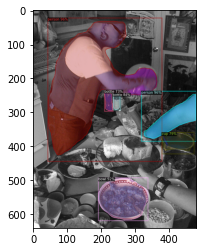

In [17]:
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
result_imgs = []
for img in imgs:
    I=plt.imread(os.path.join(img_path, img['file_name']))
    outputs = predictor(I)
    v = Visualizer(I[:, :, ::-1],
                   metadata=my_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()

    result_imgs.append(wandb_boxes(I, outputs))
    cv2.imwrite('{}.jpg'.format(img['file_name'][:-4]) ,out.get_image())
    # wandb_boxes(I, outputs, img['file_name'][:-4])
# wandb.log({"resultsv2": result_imgs})

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(reg_name, cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, reg_name)
results_i = inference_on_dataset(trainer.model, val_loader, evaluator)

[08/24 12:04:31 d2.data.datasets.coco]: Loaded 5000 images in COCO format from datasets/coco/annotations/instances_val2017.json
[08/24 12:04:32 d2.data.common]: Serializing 5000 elements to byte tensors and concatenating them all ...
[08/24 12:04:32 d2.data.common]: Serialized dataset takes 19.10 MiB
[08/24 12:04:32 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 12:04:32 d2.evaluation.evaluator]: Start inference on 5000 images
[08/24 12:04:33 d2.evaluation.evaluator]: Inference done 11/5000. 0.0721 s / img. ETA=0:07:02
[08/24 12:04:38 d2.evaluation.evaluator]: Inference done 73/5000. 0.0716 s / img. ETA=0:06:45
[08/24 12:04:43 d2.evaluation.evaluator]: Inference done 132/5000. 0.0715 s / img. ETA=0:06:46
[08/24 12:04:48 d2.evaluation.evaluator]: Inference done 191/5000. 0.0717 s / img. ETA=0:06:45


KeyboardInterrupt: 

True

In [37]:
a =vars(evaluator)

In [14]:
vars(cfg)

array([[[ 53,  53,  53],
        [ 68,  68,  68],
        [ 67,  67,  67],
        ...,
        [ 96,  96,  96],
        [ 92,  92,  92],
        [ 89,  89,  89]],

       [[ 52,  52,  52],
        [ 42,  42,  42],
        [ 32,  32,  32],
        ...,
        [ 97,  97,  97],
        [ 95,  95,  95],
        [ 66,  66,  66]],

       [[ 86,  86,  86],
        [ 84,  84,  84],
        [ 72,  72,  72],
        ...,
        [ 93,  93,  93],
        [ 86,  86,  86],
        [ 60,  60,  60]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 21,  21,  21],
        [ 26,  26,  26],
        [ 30,  30,  30]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 19,  19,  19],
        [ 19,  19,  19],
        [ 22,  22,  22]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 14,  14,  14],
        [ 24,  24,  24],
        [ 37,  37,  37]]

In [44]:
vars(result_imgs[1])

{'_path': '/tmp/tmpjpzxpnepwandb-media/2x8dkrsv.png',
 '_run': None,
 '_caption': None,
 '_grouping': None,
 '_width': 612,
 '_height': 612,
 '_image': <PIL.Image.Image image mode=RGB size=612x612 at 0x7F0BE4E14F60>,
 '_boxes': {'predictions': <wandb.data_types.BoundingBoxes2D at 0x7f0be4e78080>},
 '_masks': None,
 '_is_tmp': True,
 '_extension': None,
 '_sha256': '67fbc0d9ad39b911437ffa747c17fd20854dea099c21ef3bd58ae853b81da556',
 '_size': 616478}